### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

<font color='green'>Objective: preprocessing (converting all texts to lower case, remove punctuation, and output word-index, index-word, word frequency and corpus length)</font>

Note: Subsampling 

Subsampling is a technique that is used to remove the most frequent words in a given corpus (usually the words with minimal semantic meaning or stop words, such as 'the', 'a', etc.) 

$p(w_i) = (\sqrt{\frac{z(w_i)}{t}}+ 1)\frac{t}{z(w_i)}$

$\text{, where } z(w_i) \text{ is the frequency of the word, while t is a hyperparameter that is adjustable (normally set at 0.001, 0.0001, or 0.00001)}$

Implementation of subsampling in word2vec C code: 
```c
if (sample > 0) {
          real ran = (sqrt(vocab[word].cn / (sample * train_words)) + 1) * (sample * train_words) / vocab[word].cn;
          next_random = next_random * (unsigned long long)25214903917 + 11;
          if (ran < (next_random & 0xFFFF) / (real)65536) continue;
        }
```

### Connect to Google Drive

In [ ]:
# Import libraries for importing files from Google drive to Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authorize Google SDK to access Google Drive from Colab

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1cCKgPISArQDD1-dNbT6KJDxiQBBeDcSh'})
download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [ ]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [ ]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [ ]:
# 定義資料前處理函式
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            # hint: 請計算字詞頻率
            ### <your code> ###
            counter.update(sentence)
            processed_sentence.append(sentence)

    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        # create 
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        """ My solution derived from the C code: 
        z_wi = self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt((z_wi, self.t) + 1) * (z_wi * self.total_num_words)
        """

        # Official solution provided by instructor
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885720 words
After subsampling: 436634 words


### 定義Skip-gram使用的Dataset與collate function

In [ ]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2 *self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            all_targets += [[word] for word in line[self.window_size:-self.window_size]]
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_contexts.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for targets in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != targets[0]:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)        
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        ### <your code> 
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)
    

In [ ]:
#查看資料產出
d_set = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
dataloader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=skipgram_collate)

#透過next與iter取出資料
next(iter(dataloader))

(tensor([[9269, 8526],
         [  89, 2435]]), tensor([[1443, 1135, 1013, 4053],
         [ 596, 5935, 2034, 1623]]), tensor([[1, 0, 0, 0],
         [1, 0, 0, 0]]))

### 定義Skip-gram模型

In [ ]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = torch.mean(self.in_embedding(contexts), dim=1) # [batch * (# per docs), embed_size]
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [ ]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, 5, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [ ]:
# Start training

lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  1%|          | 1/100 [00:01<02:13,  1.35s/it]

Epoch: 1/100, Loss: 1.30317


  2%|▏         | 2/100 [00:02<02:10,  1.33s/it]

Epoch: 2/100, Loss: 0.60020


  3%|▎         | 3/100 [00:04<02:21,  1.46s/it]

Epoch: 3/100, Loss: 0.35862


  4%|▍         | 4/100 [00:05<02:14,  1.40s/it]

Epoch: 4/100, Loss: 0.24785


  5%|▌         | 5/100 [00:06<02:10,  1.37s/it]

Epoch: 5/100, Loss: 0.17981


  6%|▌         | 6/100 [00:08<02:07,  1.35s/it]

Epoch: 6/100, Loss: 0.13392


  7%|▋         | 7/100 [00:09<02:04,  1.34s/it]

Epoch: 7/100, Loss: 0.10085


  8%|▊         | 8/100 [00:10<02:02,  1.34s/it]

Epoch: 8/100, Loss: 0.07637


  9%|▉         | 9/100 [00:12<02:01,  1.33s/it]

Epoch: 9/100, Loss: 0.05793


 10%|█         | 10/100 [00:13<01:58,  1.32s/it]

Epoch: 10/100, Loss: 0.04413


 11%|█         | 11/100 [00:14<01:57,  1.31s/it]

Epoch: 11/100, Loss: 0.03380


 12%|█▏        | 12/100 [00:16<01:55,  1.32s/it]

Epoch: 12/100, Loss: 0.02613


 13%|█▎        | 13/100 [00:17<01:55,  1.32s/it]

Epoch: 13/100, Loss: 0.02048


 14%|█▍        | 14/100 [00:18<01:53,  1.32s/it]

Epoch: 14/100, Loss: 0.01627


 15%|█▌        | 15/100 [00:20<01:52,  1.32s/it]

Epoch: 15/100, Loss: 0.01308


 16%|█▌        | 16/100 [00:21<01:50,  1.32s/it]

Epoch: 16/100, Loss: 0.01067


 17%|█▋        | 17/100 [00:22<01:49,  1.31s/it]

Epoch: 17/100, Loss: 0.00879


 18%|█▊        | 18/100 [00:24<01:47,  1.31s/it]

Epoch: 18/100, Loss: 0.00732


 19%|█▉        | 19/100 [00:25<01:46,  1.31s/it]

Epoch: 19/100, Loss: 0.00613


 20%|██        | 20/100 [00:26<01:44,  1.31s/it]

Epoch: 20/100, Loss: 0.00517


 21%|██        | 21/100 [00:27<01:44,  1.32s/it]

Epoch: 21/100, Loss: 0.00439


 22%|██▏       | 22/100 [00:29<01:50,  1.41s/it]

Epoch: 22/100, Loss: 0.00375


 23%|██▎       | 23/100 [00:30<01:46,  1.39s/it]

Epoch: 23/100, Loss: 0.00324


 24%|██▍       | 24/100 [00:32<01:43,  1.36s/it]

Epoch: 24/100, Loss: 0.00279


 25%|██▌       | 25/100 [00:33<01:40,  1.34s/it]

Epoch: 25/100, Loss: 0.00241


 26%|██▌       | 26/100 [00:34<01:38,  1.33s/it]

Epoch: 26/100, Loss: 0.00208


 27%|██▋       | 27/100 [00:36<01:36,  1.32s/it]

Epoch: 27/100, Loss: 0.00181


 28%|██▊       | 28/100 [00:37<01:35,  1.32s/it]

Epoch: 28/100, Loss: 0.00158


 29%|██▉       | 29/100 [00:38<01:34,  1.33s/it]

Epoch: 29/100, Loss: 0.00138


 30%|███       | 30/100 [00:40<01:32,  1.32s/it]

Epoch: 30/100, Loss: 0.00121


 31%|███       | 31/100 [00:41<01:30,  1.32s/it]

Epoch: 31/100, Loss: 0.00107


 32%|███▏      | 32/100 [00:42<01:29,  1.32s/it]

Epoch: 32/100, Loss: 0.00094


 33%|███▎      | 33/100 [00:44<01:28,  1.32s/it]

Epoch: 33/100, Loss: 0.00083


 34%|███▍      | 34/100 [00:45<01:26,  1.31s/it]

Epoch: 34/100, Loss: 0.00073


 35%|███▌      | 35/100 [00:46<01:25,  1.32s/it]

Epoch: 35/100, Loss: 0.00065


 36%|███▌      | 36/100 [00:47<01:24,  1.31s/it]

Epoch: 36/100, Loss: 0.00057


 37%|███▋      | 37/100 [00:49<01:22,  1.31s/it]

Epoch: 37/100, Loss: 0.00051


 38%|███▊      | 38/100 [00:50<01:20,  1.30s/it]

Epoch: 38/100, Loss: 0.00045


 39%|███▉      | 39/100 [00:51<01:19,  1.31s/it]

Epoch: 39/100, Loss: 0.00040


 40%|████      | 40/100 [00:53<01:18,  1.30s/it]

Epoch: 40/100, Loss: 0.00036


 41%|████      | 41/100 [00:54<01:16,  1.30s/it]

Epoch: 41/100, Loss: 0.00032


 42%|████▏     | 42/100 [00:56<01:19,  1.38s/it]

Epoch: 42/100, Loss: 0.00028


 43%|████▎     | 43/100 [00:57<01:17,  1.35s/it]

Epoch: 43/100, Loss: 0.00025


 44%|████▍     | 44/100 [00:58<01:14,  1.34s/it]

Epoch: 44/100, Loss: 0.00023


 45%|████▌     | 45/100 [00:59<01:13,  1.33s/it]

Epoch: 45/100, Loss: 0.00024


 46%|████▌     | 46/100 [01:01<01:11,  1.32s/it]

Epoch: 46/100, Loss: 0.00018


 47%|████▋     | 47/100 [01:02<01:09,  1.31s/it]

Epoch: 47/100, Loss: 0.00016


 48%|████▊     | 48/100 [01:03<01:07,  1.30s/it]

Epoch: 48/100, Loss: 0.00014


 49%|████▉     | 49/100 [01:05<01:06,  1.31s/it]

Epoch: 49/100, Loss: 0.00013


 50%|█████     | 50/100 [01:06<01:05,  1.30s/it]

Epoch: 50/100, Loss: 0.00011


 51%|█████     | 51/100 [01:07<01:03,  1.30s/it]

Epoch: 51/100, Loss: 0.00010


 52%|█████▏    | 52/100 [01:08<01:02,  1.29s/it]

Epoch: 52/100, Loss: 0.00009


 53%|█████▎    | 53/100 [01:10<01:00,  1.30s/it]

Epoch: 53/100, Loss: 0.00008


 54%|█████▍    | 54/100 [01:11<00:59,  1.30s/it]

Epoch: 54/100, Loss: 0.00007


 55%|█████▌    | 55/100 [01:12<00:58,  1.30s/it]

Epoch: 55/100, Loss: 0.00007


 56%|█████▌    | 56/100 [01:14<00:57,  1.30s/it]

Epoch: 56/100, Loss: 0.00006


 57%|█████▋    | 57/100 [01:15<00:56,  1.30s/it]

Epoch: 57/100, Loss: 0.00005


 58%|█████▊    | 58/100 [01:16<00:54,  1.31s/it]

Epoch: 58/100, Loss: 0.00005


 59%|█████▉    | 59/100 [01:18<00:53,  1.31s/it]

Epoch: 59/100, Loss: 0.00004


 60%|██████    | 60/100 [01:19<00:52,  1.31s/it]

Epoch: 60/100, Loss: 0.00004


 61%|██████    | 61/100 [01:21<00:54,  1.40s/it]

Epoch: 61/100, Loss: 0.00004


 62%|██████▏   | 62/100 [01:22<00:52,  1.38s/it]

Epoch: 62/100, Loss: 0.00003


 63%|██████▎   | 63/100 [01:23<00:50,  1.36s/it]

Epoch: 63/100, Loss: 0.00003


 64%|██████▍   | 64/100 [01:24<00:48,  1.35s/it]

Epoch: 64/100, Loss: 0.00003


 65%|██████▌   | 65/100 [01:26<00:46,  1.34s/it]

Epoch: 65/100, Loss: 0.00002


 66%|██████▌   | 66/100 [01:27<00:45,  1.33s/it]

Epoch: 66/100, Loss: 0.00002


 67%|██████▋   | 67/100 [01:28<00:43,  1.33s/it]

Epoch: 67/100, Loss: 0.00002


 68%|██████▊   | 68/100 [01:30<00:42,  1.32s/it]

Epoch: 68/100, Loss: 0.00002


 69%|██████▉   | 69/100 [01:31<00:41,  1.32s/it]

Epoch: 69/100, Loss: 0.00002


 70%|███████   | 70/100 [01:32<00:39,  1.32s/it]

Epoch: 70/100, Loss: 0.00001


 71%|███████   | 71/100 [01:34<00:38,  1.32s/it]

Epoch: 71/100, Loss: 0.00001


 72%|███████▏  | 72/100 [01:35<00:36,  1.31s/it]

Epoch: 72/100, Loss: 0.00001


 73%|███████▎  | 73/100 [01:36<00:35,  1.31s/it]

Epoch: 73/100, Loss: 0.00001


 74%|███████▍  | 74/100 [01:38<00:34,  1.31s/it]

Epoch: 74/100, Loss: 0.00001


 75%|███████▌  | 75/100 [01:39<00:32,  1.32s/it]

Epoch: 75/100, Loss: 0.00001


 76%|███████▌  | 76/100 [01:40<00:31,  1.32s/it]

Epoch: 76/100, Loss: 0.00001


 77%|███████▋  | 77/100 [01:42<00:30,  1.31s/it]

Epoch: 77/100, Loss: 0.00001


 78%|███████▊  | 78/100 [01:43<00:28,  1.30s/it]

Epoch: 78/100, Loss: 0.00001


 79%|███████▉  | 79/100 [01:44<00:27,  1.31s/it]

Epoch: 79/100, Loss: 0.00001


 80%|████████  | 80/100 [01:46<00:27,  1.38s/it]

Epoch: 80/100, Loss: 0.00001


 81%|████████  | 81/100 [01:47<00:25,  1.35s/it]

Epoch: 81/100, Loss: 0.00001


 82%|████████▏ | 82/100 [01:48<00:24,  1.34s/it]

Epoch: 82/100, Loss: 0.00000


 83%|████████▎ | 83/100 [01:50<00:22,  1.32s/it]

Epoch: 83/100, Loss: 0.00000


 84%|████████▍ | 84/100 [01:51<00:21,  1.31s/it]

Epoch: 84/100, Loss: 0.00000


 85%|████████▌ | 85/100 [01:52<00:19,  1.30s/it]

Epoch: 85/100, Loss: 0.00000


 86%|████████▌ | 86/100 [01:53<00:18,  1.30s/it]

Epoch: 86/100, Loss: 0.00000


 87%|████████▋ | 87/100 [01:55<00:16,  1.30s/it]

Epoch: 87/100, Loss: 0.00000


 88%|████████▊ | 88/100 [01:56<00:15,  1.30s/it]

Epoch: 88/100, Loss: 0.00000


 89%|████████▉ | 89/100 [01:57<00:14,  1.30s/it]

Epoch: 89/100, Loss: 0.00000


 90%|█████████ | 90/100 [01:59<00:12,  1.29s/it]

Epoch: 90/100, Loss: 0.00000


 91%|█████████ | 91/100 [02:00<00:11,  1.29s/it]

Epoch: 91/100, Loss: 0.00000


 92%|█████████▏| 92/100 [02:01<00:10,  1.29s/it]

Epoch: 92/100, Loss: 0.00000


 93%|█████████▎| 93/100 [02:03<00:09,  1.29s/it]

Epoch: 93/100, Loss: 0.00000


 94%|█████████▍| 94/100 [02:04<00:07,  1.29s/it]

Epoch: 94/100, Loss: 0.00000


 95%|█████████▌| 95/100 [02:05<00:06,  1.29s/it]

Epoch: 95/100, Loss: 0.00000


 96%|█████████▌| 96/100 [02:06<00:05,  1.29s/it]

Epoch: 96/100, Loss: 0.00000


 97%|█████████▋| 97/100 [02:08<00:03,  1.29s/it]

Epoch: 97/100, Loss: 0.00000


 98%|█████████▊| 98/100 [02:09<00:02,  1.30s/it]

Epoch: 98/100, Loss: 0.00000


 99%|█████████▉| 99/100 [02:10<00:01,  1.30s/it]

Epoch: 99/100, Loss: 0.00000


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Epoch: 100/100, Loss: 0.00000


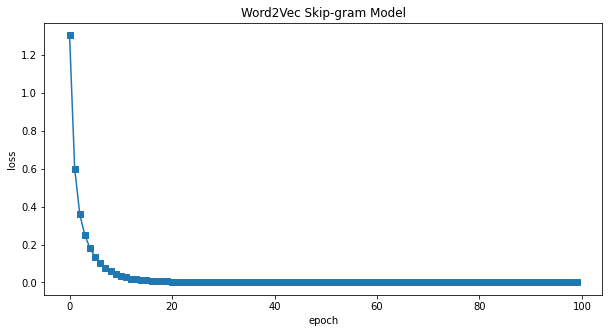

In [ ]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [ ]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine similarity between ‘{word}’ and ‘{idx2word[int(i)]}’:  = {cos[int(i)]:.3f}")

get_similarity('love', 20, model, word2idx, idx2word)

cosine similarity between ‘love’ and ‘correct’:  = 0.354
cosine similarity between ‘love’ and ‘dates’:  = 0.352
cosine similarity between ‘love’ and ‘adm.’:  = 0.345
cosine similarity between ‘love’ and ‘diplomat’:  = 0.341
cosine similarity between ‘love’ and ‘exotic’:  = 0.337
cosine similarity between ‘love’ and ‘remedy’:  = 0.337
cosine similarity between ‘love’ and ‘prevent’:  = 0.331
cosine similarity between ‘love’ and ‘mood’:  = 0.324
cosine similarity between ‘love’ and ‘taking’:  = 0.321
cosine similarity between ‘love’ and ‘pages’:  = 0.318
cosine similarity between ‘love’ and ‘smart’:  = 0.310
cosine similarity between ‘love’ and ‘ideological’:  = 0.310
cosine similarity between ‘love’ and ‘10-year’:  = 0.309
cosine similarity between ‘love’ and ‘create’:  = 0.307
cosine similarity between ‘love’ and ‘have’:  = 0.305
cosine similarity between ‘love’ and ‘afraid’:  = 0.304
cosine similarity between ‘love’ and ‘dead’:  = 0.303
cosine similarity between ‘love’ and ‘daf’:  = 0.